# **1.5 CNN Using PyTorch**

## 1.6 Loading the CIFAR10 Dataset

In [85]:
#download CIFAR10 dataset from pytorch
import torch
import torchvision

# First we define 'Hyperparameters'
num_epochs = 50
num_classes = 10
batch_size = 4
learning_rate = 0.001
DEBUG = False
DEBUG_DETAILED = False

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
# split trainset with 10% for validation using this method:
# https://stackoverflow.com/questions/64092369/validation-dataset-in-pytorch-using-dataloaders
train_subset, val_subset = torch.utils.data.random_split(trainset, [45000, 5000], torch.Generator().manual_seed(1))
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

# we get our testset and create a test_loader:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

print(f"trainset.shape == {trainset.data.shape}")
print(f"testset.shape == {testset.data.shape}")
print(f"train_loader.length == {len(train_loader.dataset.indices)}")
print(f"val_loader.length == {len(val_loader.dataset.indices)}")

Files already downloaded and verified
Files already downloaded and verified
trainset.shape == (50000, 32, 32, 3)
testset.shape == (10000, 32, 32, 3)
train_loader.length == 45000
val_loader.length == 5000


## 1.7 Implementing the Network

In [86]:
# Initially using MNIST tutorial:
# https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
# convolution formula: [(W−K+2P)/S]+1, W is 32, K kernel, p padding, s stride.
# maxpool formula: (W-K)/s +1


class PyTorchNet(torch.nn.Module):
  def __init__(self):
    super(PyTorchNet, self).__init__()

    self.cnn_layers = torch.nn.Sequential(
        # we start with shape: [batch_size,3,32,32]
        torch.nn.Conv2d(in_channels=3,out_channels=24,kernel_size=5,stride=1,padding=0),
        # size is now [batch_size,24,28,28]
        torch.nn.ReLU(inplace=True),
        torch.nn.LayerNorm(normalized_shape=[24,28,28]),
        torch.nn.MaxPool2d(2,2),
        # size is now [batch_size,24,14,14]
        torch.nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5,stride=1,padding=0),
        # size is now [batch_size,48,10,10]
        torch.nn.ReLU(inplace=True),
        torch.nn.LayerNorm(normalized_shape=[48,10,10]),
        torch.nn.MaxPool2d(2,2),
        )
    
    # size is now [batch_size,48,5,5]
    # we flatten to [batch_size,1200] in forward()
    self.linear_layers = torch.nn.Sequential(
        torch.nn.Dropout(inplace=True),
        torch.nn.Linear(1200, 500),
        torch.nn.Linear(500, 100),
        torch.nn.Linear(100, 50),
        torch.nn.Linear(50,10),
        torch.nn.Softmax(dim=1)
    )


  def forward(self, input):
    if DEBUG or DEBUG_DETAILED:
      print("Running forward")

    out = self.cnn_layers(input)
    out = out.view(-1, 1200)
    out = self.linear_layers(out)

    return out

### Training the Model

In [87]:
import time

use_gpu = 1
if use_gpu:
    model = PyTorchNet().cuda()
else:
    model = PyTorchNet()

# we create the loss and optimizers:
# cross entropy here combines logistic softmax.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# len(dataloader) returns len(dataset)/batch_size
train_total_steps = len(train_loader)
val_total_steps = len(val_loader)
loss_list = []
acc_list = []
train_print_every = round(train_total_steps/5)
val_print_every = round(val_total_steps/2)
start_time = None
elapsed_time = None

# using this design:
# https://discuss.pytorch.org/t/accuracy-for-training-and-validation-dont-update-or-change/74871
for epoch in range(num_epochs):
  print(f"EPOCH [{epoch + 1}/{num_epochs}]", end="")
  
  if elapsed_time is not None:
    elapsed_time = elapsed_time*(num_epochs-epoch)
    print(f"\tTime Remaining: {int((elapsed_time//60)//60)}:{int((elapsed_time//60)%60)}:{int(elapsed_time%60)}", end="")
    print(f'\tETC: {time.strftime("%I:%Mp", time.localtime(time.time()+elapsed_time))}')

  start_time = time.process_time()

  train_loss = 0.0
  val_loss = 0.0

  train_total = 0
  val_total = 0

  train_correct = 0
  val_correct = 0

  # Training Phase
  print("\tTraining...")
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    if use_gpu:
      try:
        images, labels = images.cuda(), labels.cuda()
      except RuntimeError as e:
        print(e)
        print("Use cpu.")
    
    output = model(images)
    if DEBUG_DETAILED:
      print(f"outputs.data[0] == {outputs.data[0]}")
      print(f"labels.data == {labels.data}")
    loss = criterion(output, labels)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_total += labels.size(0)
    train_loss += loss.item()*images.size(0)
    _, predicted = torch.max(output.data, 1)
    if DEBUG_DETAILED:
      print(f"predicted == {predicted}")
      print(f"predicted == labels == {(predicted == labels)}")
      print(f"predicted==labels.sum() == {(predicted == labels).sum()}")
      print(f"total == {total}")
    train_correct += int(sum(predicted == labels))
    accuracy = round((train_correct/train_total)*100, 2)
    acc_list.append(accuracy)

    if (i+1) % train_print_every == 0:
      print(f"\tStep [{i + 1}/{train_total_steps}],", end="")
      print("Loss: {:.4f}, Accuracy: {:.2f}% ({}/{})".format(train_loss/train_total, accuracy, train_correct, train_total))


  # Validating Phase
  print("\tValidating...")
  model.eval()
  for i, (images, labels) in enumerate(val_loader):
    if use_gpu:
      try:
        images, labels = images.cuda(), labels.cuda()
      except RuntimeError as e:
        print(e)
        print("Use cpu.")
    output = model(images)
    loss = criterion(output, labels)
    val_loss += loss.item()*images.size(0)
    _, predicted = torch.max(output.data, 1)
    val_total += labels.size(0)
    val_correct += int(sum(predicted == labels))
    val_acc = round((val_correct/val_total)*100, 2)
    if (i+1) % val_print_every == 0:
      print(f"\tStep [{i + 1}/{val_total_steps}],", end="")
      print("Loss: {:.4f}, Accuracy: {:.2f}% ({}/{})".format(val_loss/val_total, val_acc, val_correct, val_total))


  # display acc/loss for every EPOCH:
  train_loss = round((train_loss/len(train_loader.sampler)), 5)
  val_loss = round((val_loss/len(val_loader.sampler)), 5)
  print(f"t_loss:{train_loss} t_acc:{accuracy} v_loss:{val_loss} v_acc:{val_acc}")
  
  elapsed_time = time.process_time() - start_time

EPOCH [1/50]	Training...
	Step [2250/11250],Loss: 2.2953, Accuracy: 15.47% (1392/9000)
	Step [4500/11250],Loss: 2.2796, Accuracy: 19.34% (3482/18000)
	Step [6750/11250],Loss: 2.2589, Accuracy: 21.26% (5741/27000)
	Step [9000/11250],Loss: 2.2403, Accuracy: 22.92% (8251/36000)
	Step [11250/11250],Loss: 2.2230, Accuracy: 24.67% (11101/45000)
	Validating...
	Step [625/1250],Loss: 2.1345, Accuracy: 34.04% (851/2500)
	Step [1250/1250],Loss: 2.1331, Accuracy: 34.08% (1704/5000)
t_loss:2.22302 t_acc:24.67 v_loss:2.13314 v_acc:34.08
EPOCH [2/50]	Time Remaining: 0:30:35	ETC: 09:50p
	Training...
	Step [2250/11250],Loss: 2.1179, Accuracy: 35.91% (3232/9000)
	Step [4500/11250],Loss: 2.1042, Accuracy: 37.36% (6725/18000)
	Step [6750/11250],Loss: 2.0885, Accuracy: 38.89% (10501/27000)
	Step [9000/11250],Loss: 2.0777, Accuracy: 39.83% (14337/36000)
	Step [11250/11250],Loss: 2.0672, Accuracy: 40.80% (18359/45000)
	Validating...
	Step [625/1250],Loss: 2.0050, Accuracy: 47.04% (1176/2500)
	Step [1250/125

	Step [9000/11250],Loss: 1.8077, Accuracy: 65.37% (23532/36000)
	Step [11250/11250],Loss: 1.8070, Accuracy: 65.43% (29443/45000)
	Validating...
	Step [625/1250],Loss: 1.7857, Accuracy: 67.32% (1683/2500)
	Step [1250/1250],Loss: 1.7955, Accuracy: 66.56% (3328/5000)
t_loss:1.80701 t_acc:65.43 v_loss:1.79548 v_acc:66.56
EPOCH [16/50]	Time Remaining: 0:21:28	ETC: 09:49p
	Training...
	Step [2250/11250],Loss: 1.8019, Accuracy: 65.74% (5917/9000)
	Step [4500/11250],Loss: 1.8008, Accuracy: 65.94% (11869/18000)
	Step [6750/11250],Loss: 1.8008, Accuracy: 65.94% (17804/27000)
	Step [9000/11250],Loss: 1.8001, Accuracy: 65.99% (23756/36000)
	Step [11250/11250],Loss: 1.8017, Accuracy: 65.80% (29611/45000)
	Validating...
	Step [625/1250],Loss: 1.7822, Accuracy: 67.96% (1699/2500)
	Step [1250/1250],Loss: 1.7887, Accuracy: 67.24% (3362/5000)
t_loss:1.80169 t_acc:65.8 v_loss:1.78867 v_acc:67.24
EPOCH [17/50]	Time Remaining: 0:20:47	ETC: 09:49p
	Training...
	Step [2250/11250],Loss: 1.7899, Accuracy: 66.8

	Step [1250/1250],Loss: 1.7692, Accuracy: 69.40% (3470/5000)
t_loss:1.76264 t_acc:69.73 v_loss:1.76919 v_acc:69.4
EPOCH [30/50]	Time Remaining: 0:13:49	ETC: 09:50p
	Training...
	Step [2250/11250],Loss: 1.7678, Accuracy: 69.22% (6230/9000)
	Step [4500/11250],Loss: 1.7648, Accuracy: 69.52% (12513/18000)
	Step [6750/11250],Loss: 1.7625, Accuracy: 69.71% (18823/27000)
	Step [9000/11250],Loss: 1.7635, Accuracy: 69.63% (25066/36000)
	Step [11250/11250],Loss: 1.7636, Accuracy: 69.61% (31325/45000)
	Validating...
	Step [625/1250],Loss: 1.7591, Accuracy: 70.20% (1755/2500)
	Step [1250/1250],Loss: 1.7653, Accuracy: 69.62% (3481/5000)
t_loss:1.76364 t_acc:69.61 v_loss:1.76529 v_acc:69.62
EPOCH [31/50]	Time Remaining: 0:12:27	ETC: 09:49p
	Training...
	Step [2250/11250],Loss: 1.7575, Accuracy: 70.34% (6331/9000)
	Step [4500/11250],Loss: 1.7561, Accuracy: 70.43% (12677/18000)
	Step [6750/11250],Loss: 1.7599, Accuracy: 70.02% (18905/27000)
	Step [9000/11250],Loss: 1.7605, Accuracy: 69.93% (25174/3600

	Step [4500/11250],Loss: 1.7426, Accuracy: 71.74% (12914/18000)
	Step [6750/11250],Loss: 1.7417, Accuracy: 71.88% (19407/27000)
	Step [9000/11250],Loss: 1.7420, Accuracy: 71.81% (25852/36000)
	Step [11250/11250],Loss: 1.7435, Accuracy: 71.68% (32256/45000)
	Validating...
	Step [625/1250],Loss: 1.7423, Accuracy: 72.00% (1800/2500)
	Step [1250/1250],Loss: 1.7462, Accuracy: 71.46% (3573/5000)
t_loss:1.74355 t_acc:71.68 v_loss:1.74622 v_acc:71.46
EPOCH [45/50]	Time Remaining: 0:3:41	ETC: 09:49p
	Training...
	Step [2250/11250],Loss: 1.7445, Accuracy: 71.48% (6433/9000)
	Step [4500/11250],Loss: 1.7453, Accuracy: 71.43% (12858/18000)
	Step [6750/11250],Loss: 1.7442, Accuracy: 71.52% (19310/27000)
	Step [9000/11250],Loss: 1.7447, Accuracy: 71.53% (25750/36000)
	Step [11250/11250],Loss: 1.7435, Accuracy: 71.64% (32237/45000)
	Validating...
	Step [625/1250],Loss: 1.7430, Accuracy: 71.68% (1792/2500)
	Step [1250/1250],Loss: 1.7470, Accuracy: 71.12% (3556/5000)
t_loss:1.74348 t_acc:71.64 v_loss:1.

### Testing the Model

In [88]:
# batch size should not matter when model is in eval mode.
model.eval()
correct = 0
total = 0

print("Testing...")
with torch.no_grad():
  for images, labels in test_loader:
    if use_gpu:
        images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Accuracy: {round((correct/total) * 100, 2)}%")

Testing...
Accuracy: 71.37%


## 1.8 Predicting

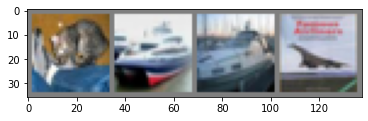

     test labels:    cat   ship   ship  plane
predicted labels:    cat    car    car   ship


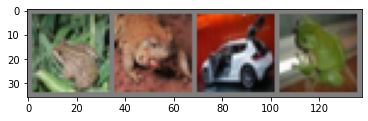

     test labels:   frog   frog    car   frog
predicted labels:   frog   frog    car   frog


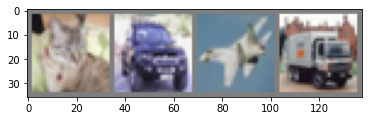

     test labels:    cat    car  plane  truck
predicted labels:    cat    car  plane  truck


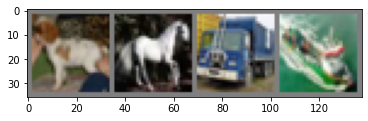

     test labels:    dog  horse  truck   ship
predicted labels:    cat  horse  truck   frog


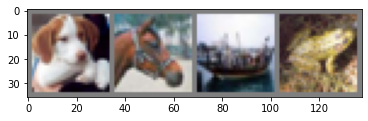

     test labels:    dog  horse   ship   frog
predicted labels:    dog  horse   ship   frog


In [89]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_comparisons = 5

# get some random training images
dataiter = iter(test_loader)
for i in range(num_comparisons):
  images, labels = dataiter.next()
  if use_gpu:
    images, labels = images.cuda(), labels.cuda()
  output = model(images)
  _, y_pred = torch.max(output.data, 1)

  # show images
  imshow(torchvision.utils.make_grid(images.cpu()))

  # print labels
  print("     test labels: " + ' '.join('%6s' % classes[labels[j]] for j in range(batch_size)))
  print("predicted labels: " + ' '.join('%6s' % classes[y_pred[j]] for j in range(batch_size)))

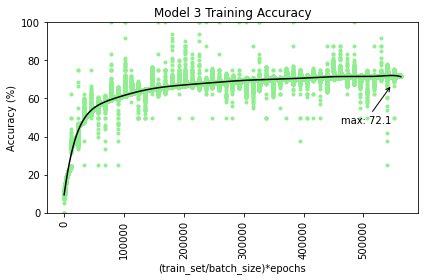

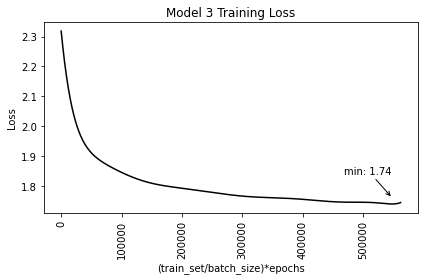

In [90]:
def plot_accuracy(acc_list: list = [], title: str = ""):
    """Calculates the trendline for a models list of stored
    accuracies during training. Annotates the plot with an
    arrow and max value."""
    
    x = range(len(acc_list))
    y = acc_list
    
    z = np.polyfit(x, y, 10)
    p = np.poly1d(z)
    trnd_ln_arr = p(x)
    
    plt.plot(x, y, '.', color='lightgreen')
    plt.plot(x, trnd_ln_arr, color='black')
    plt.xticks(rotation=90)
    
    y_max = round(max(p(x)), 2)
    x_pos = np.argmax(trnd_ln_arr, 0)
    x_max = x[x_pos]

    plt.annotate(f"max: {y_max}",xy=(x_max, y_max-5), xytext=(x_max, y_max-25),horizontalalignment='right', arrowprops=dict(arrowstyle='->',facecolor='black'))
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.xlabel("(train_set/batch_size)*epochs")
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

def plot_loss(loss_list: list = [], title: str = ""):
    x = range(len(loss_list))
    y = loss_list
    
    z = np.polyfit(x, y, 10)
    p = np.poly1d(z)
    trnd_ln_arr = p(x)
    
    plt.plot(x, trnd_ln_arr, color='black')
    plt.xticks(rotation=90)
    
    ymin = round(min(p(x)), 2)
    x_pos = np.argmin(trnd_ln_arr, 0)
    xmin = x[x_pos]

    plt.annotate(f"min: {ymin}",xy=(xmin, ymin+.02), xytext=(xmin, ymin+.1),horizontalalignment='right', arrowprops=dict(arrowstyle='->',facecolor='black'))
    plt.ylabel("Loss")
    plt.xlabel("(train_set/batch_size)*epochs")
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

plot_accuracy(acc_list, "Model 3 Training Accuracy")
plot_loss(loss_list, "Model 3 Training Loss")


In [91]:
from torchsummary import summary
print(model)
summary(model.cuda(), (3, 32, 32))

PyTorchNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): LayerNorm((24, 28, 28), eps=1e-05, elementwise_affine=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): LayerNorm((48, 10, 10), eps=1e-05, elementwise_affine=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=1200, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   

In [92]:
from win10toast import ToastNotifier
toast = ToastNotifier()
toast.show_toast("Jupyter Notebook","Execution Completed.",duration=5,icon_path="icon.ico")

True

# **Methods Used and Results:**

## First Method
{loss: 1.70; acc: 76.74%; v_loss: 1.79; v_acc: 66.84%, test_acc: 67.58%; Epochs: 50; batch_size:4; lr:0.001}
```
# Start with Size [200,3,32,32] in Layer 1.
Conv2d(3,32,5,1,2) => [200,32,32,32]
ReLU(), Maxpooling2d(2,2) => [200,32,16,16]
# Second layer is the same:
Conv2d(32,64,5,1,2) => [200,64,16,16]
ReLU(), Maxpooling2d(2,2) => [200,64,8,8]
# Third layer is a repeat:
Conv2d(64,128,5,1,2) => [200,128,8,8]
ReLU(), Maxpooling2d(2,2) => [200,128,4,4]
# Next is FC layers:
Flatten()
ReLU()
Linear(2048,1024)
Linear(1024,10)
Softmax(dim=1)
```
> **ANALYSIS:** The first try was akin to throwing mud at the wall. This was a similar model used for the MNIST dataset. I wanted to see if it would would for any 2d inputs. Both MNIST and CIFAR10 are classification datasets. The major difference being that MNIST is only 1-channel, while CIFAR10 has 3-channel images. I got somewhat alright accuracy (67.58) with no normalization layers.

![picture](https://drive.google.com/uc?export=view&id=17tqEuwgiwe0MDsV1z1G_8A0gQKYZAjyX)
![picture](https://drive.google.com/uc?export=view&id=1uZ5y6X7OJ3i0SQA8t3SgDFlK80gFTnp4)
## Second Method
{loss: 1.91; acc: 54.49%; v_loss: 1.84; v_acc: 60.78%, test_acc: 61.03%; Epochs: 50; batch_size:4; lr:0.001}
```
# I used the model used in the PyTorch tutorial on CIFAR10
# found here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0),
# size is now [200,6,28,28]
torch.nn.ReLU(inplace=True),
torch.nn.BatchNorm2d(6),
torch.nn.MaxPool2d(2,2),
# size is now [200,6,14,14]
torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0),
# size is now [200,16,10,10]
torch.nn.ReLU(inplace=True),
torch.nn.BatchNorm2d(16),
torch.nn.MaxPool2d(2,2)
# size is now [200,16,5,5]
# now we flatten into linear layers
torch.nn.Dropout(inplace=True),
torch.nn.Linear(400, 200),
torch.nn.Linear(200, 120),
torch.nn.Linear(120, 84),
torch.nn.Linear(84,10),
torch.nn.Softmax(dim=1)
```
> **ANALYSIS:** I used the model used in the PyTorch tutorial on CIFAR10 found here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. I adapted this model to fit the ***requirements of the homework***. I added **normalization,pooling after every cnn, used ReLU and gradient descent. I also had softmax after the last linear FC layer.** Within 50 epochs, I had a great increase in accuracy with testing resulting in 61.03%. Adding the dropout seems to have helped the most in both the training and validation phases. The main differences between the tutorial and my model are as follows:
1.   I added BatchNorm2d and ReLU after every Conv2d Layer, as per the HW requirements.
2.   I implemented a dropout right after the convolutional layers.
3.   I added more fully-connected linear layers, and removed the ReLU activation between them.
4.   I added Softmax to the last linear layer, as is the norm with classification models, and is also a HW requirement.

> We ran this model with 100 epochs in hopes of getting our accuracy up. Our results were {loss: 1.90; acc: 55.58%; v_loss: 1.84; v_acc: 61.2%, test_acc: 61.31%; Epochs: 100; batch_size:4; lr:0.001}. We noticed no significant improvement in accuracy.

![picture](https://drive.google.com/uc?export=view&id=1m0mfsdsrVnVTQIqNJQ5TDQZfxjqyO6Tc)
![picture](https://drive.google.com/uc?export=view&id=1ONwDjWVb30x7qCoGH4c8QqwDo-xuB9dI)
# Third Method
{loss: 1.74; acc: 71.96%; v_loss: 1.75; v_acc: 70.40%, test_acc: 71.68%; Epochs: 50; batch_size:4; lr:0.001}
```
# we start with shape: [batch_size,3,32,32]
torch.nn.Conv2d(in_channels=3,out_channels=24,kernel_size=5,stride=1,padding=0),
# size is now [batch_size,6,28,28]
torch.nn.ReLU(inplace=True),
torch.nn.LayerNorm(normalized_shape=[batch_size,24,28,28]),
torch.nn.MaxPool2d(2,2),
# size is now [batch_size,6,14,14]
torch.nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5,stride=1,padding=0),
# size is now [batch_size,16,10,10]
torch.nn.ReLU(inplace=True),
torch.nn.LayerNorm(normalized_shape=[batch_size,48,10,10]),
torch.nn.MaxPool2d(2,2)
# we reshape in forward()
```
> **ANALYSIS** This method yielded better results. Its main difference from method 2 is that we substituted LayerNorm for BatchNorm2d. This led to a significant increase in accuracy. This model therefore fullfills all requirements of the homework by earning the 70% required accuracy. We also increased the number of out_channels in both convolutional layers.

![picture](https://drive.google.com/uc?export=view&id=1fnnjAOEz1YW0GFDmE1WUbIuSOvz7Y7KI)
![picture](https://drive.google.com/uc?export=view&id=13FajxKHMmv-VcJM5vxCa1pI3gfJvWlMz)